In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

import scipy.cluster.hierarchy as shc

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### Get data and gb day and flavor

In [2]:
#create list of dir paths
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/data/comb'
    
path_file_names = os.listdir(path)

data_paths = []

for file in path_file_names:
    int_path = path + '/' + file
    data_paths.append(int_path)
    
data_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/data/comb/flavor_orig.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID/data/comb/flavor_switch.csv']

In [3]:
data_switch = pd.read_csv(data_paths[1])
data_switch = pd.DataFrame(data = data_switch)
data_switch.head()

,Cage,IdRFID,Sex,Cage_N,VDM_file,Cage_VDM,Flavor,value,VDM_date,VDM_time,day_count,VDM_hour,VDM_min,VDM_second,ld_seg,RFID_eventDuration,ld_cycle,ld_day,min_count,sec_count,hour_count_running,min_count_running,sec_count_running
0,3,041AC00A9F,female,3,br.c.g.o_switchfm_211220.csv,3,grape,0.054,12/20/21,12:58:17,1,12,58,17,light,5.817,light,light_day1,778,46697,12,778,46637
1,6,041AC033A1,female,3,br.c.g.o_switchfm_211220.csv,6,cherry,0.021,12/20/21,12:58:19,1,12,58,19,light,9.079,light,light_day1,778,46699,12,778,46639
2,6,041AC033A1,female,3,br.c.g.o_switchfm_211220.csv,6,cherry,0.021,12/20/21,12:58:22,1,12,58,22,light,9.079,light,light_day1,778,46702,12,778,46642
3,1,041ABFF7BD,male,3,br.c.g.o_switchfm_211220.csv,1,grape,0.021,12/20/21,12:59:05,1,12,59,5,light,10.592,light,light_day1,779,46745,12,779,46685
4,6,041AC028F2,female,3,br.c.g.o_switchfm_211220.csv,6,cherry,0.021,12/20/21,12:59:15,1,12,59,15,light,2.440,light,light_day1,779,46755,12,779,46695


In [40]:
data_gb_daysum = data_switch.groupby(['VDM_file', 'Sex', 'Cage', 'IdRFID', 'day_count', 
                                   'Flavor', 'ld_cycle'])['value',].sum().reset_index()

data_gb_daysum.head()

,VDM_file,Sex,Cage,IdRFID,day_count,Flavor,ld_cycle,value
0,br.c.g.o_switchfm_211220.csv,female,3,041ABFE8D4,1,blueras,dark,0.050
1,br.c.g.o_switchfm_211220.csv,female,3,041ABFE8D4,1,grape,dark,1.026
2,br.c.g.o_switchfm_211220.csv,female,3,041ABFE8D4,1,orange,dark,0.336
3,br.c.g.o_switchfm_211220.csv,female,3,041ABFE8D4,2,blueras,dark,0.050
4,br.c.g.o_switchfm_211220.csv,female,3,041ABFE8D4,2,grape,dark,2.430


#### want a single row per animal

In [41]:
unstack_flavor_params = ['Sex', 'Cage', 'IdRFID', 'day_count', 'Flavor', 'value', 'ld_cycle']

unstack_flavor = data_gb_daysum[unstack_flavor_params].set_index(['Sex', 'Cage', 'IdRFID', 'day_count', 'ld_cycle', 'Flavor']).unstack(-1).reset_index()
unstack_flavor.columns = ['Sex', 'Cage', 'IdRFID', 'day_count', 'ld_cycle', 'blueras', 'cherry', 'grape', 'orange']

unstack_flavor.head()

,Sex,Cage,IdRFID,day_count,ld_cycle,blueras,cherry,grape,orange
0,female,3,041ABFE8D4,1,dark,0.050,NaN,1.026,0.336
1,female,3,041ABFE8D4,2,dark,0.050,NaN,2.430,0.480
2,female,3,041ABFE8D4,2,light,NaN,NaN,0.162,0.168
3,female,3,041ABFE8D4,3,dark,0.425,NaN,1.404,1.560
4,female,3,041ABFE8D4,3,light,NaN,NaN,0.324,0.096


In [44]:
unstack_flavor_day = unstack_flavor.set_index(['Sex', 'Cage', 'IdRFID', 'ld_cycle', 'day_count',]).unstack(-1).reset_index()

unstack_flavor_day.columns = ['Sex', 'Cage', 'IdRFID', 'ld_cycle',
                              'blueras1', 'blueras2', 'blueras3', 'blueras4',
                                'cherry1', 'cherry2', 'cherry3', 'cherry4',
                                'grape1', 'grape2', 'grape3', 'grape4',
                                'orange1', 'orange2', 'orange3', 'orange4',]

print(unstack_flavor_day.shape)
unstack_flavor_day.head()

(48, 20)


,Sex,Cage,IdRFID,ld_cycle,blueras1,blueras2,blueras3,blueras4,cherry1,cherry2,cherry3,cherry4,grape1,grape2,grape3,grape4,orange1,orange2,orange3,orange4
0,female,3,041ABFE8D4,dark,0.050,0.050,0.425,0.20,NaN,NaN,NaN,NaN,1.026,2.430,1.404,0.621,0.336,0.480,1.560,0.120
1,female,3,041ABFE8D4,light,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.162,0.324,NaN,NaN,0.168,0.096,0.120
2,female,3,041AC00A9F,dark,0.100,0.050,0.075,0.15,NaN,0.022,0.022,NaN,0.621,1.134,1.323,0.702,0.408,1.200,1.392,0.360
3,female,3,041AC00A9F,light,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054,0.270,0.972,NaN,0.288,0.504,NaN,NaN
4,female,3,041AC03717,dark,0.975,0.525,0.375,0.75,NaN,0.022,0.066,NaN,NaN,1.269,1.215,0.783,0.360,1.176,1.368,0.024


In [45]:
unstack_flavor_day = unstack_flavor_day.fillna(0)

unstack_flavor_day.head()

,Sex,Cage,IdRFID,ld_cycle,blueras1,blueras2,blueras3,blueras4,cherry1,cherry2,cherry3,cherry4,grape1,grape2,grape3,grape4,orange1,orange2,orange3,orange4
0,female,3,041ABFE8D4,dark,0.050,0.050,0.425,0.20,0.0,0.000,0.000,0.0,1.026,2.430,1.404,0.621,0.336,0.480,1.560,0.120
1,female,3,041ABFE8D4,light,0.000,0.000,0.000,0.05,0.0,0.000,0.000,0.0,0.000,0.162,0.324,0.000,0.000,0.168,0.096,0.120
2,female,3,041AC00A9F,dark,0.100,0.050,0.075,0.15,0.0,0.022,0.022,0.0,0.621,1.134,1.323,0.702,0.408,1.200,1.392,0.360
3,female,3,041AC00A9F,light,0.000,0.000,0.000,0.00,0.0,0.000,0.000,0.0,0.054,0.270,0.972,0.000,0.288,0.504,0.000,0.000
4,female,3,041AC03717,dark,0.975,0.525,0.375,0.75,0.0,0.022,0.066,0.0,0.000,1.269,1.215,0.783,0.360,1.176,1.368,0.024


### Cluster

In [46]:
day_cluster = unstack_flavor_day[['blueras1', 'blueras2', 'blueras3', 'blueras4',
                                'cherry1', 'cherry2', 'cherry3', 'cherry4',
                                'grape1', 'grape2', 'grape3', 'grape4',
                                'orange1', 'orange2', 'orange3', 'orange4',]]

# center and scale the data
scaler = StandardScaler()
#scaler = RobustScaler()

day_cluster_scaled = scaler.fit_transform(day_cluster)

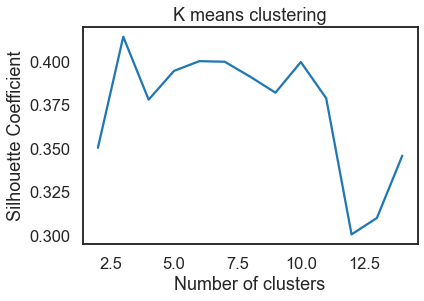

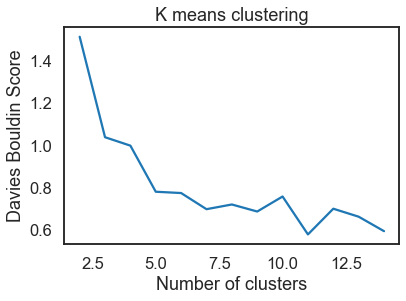

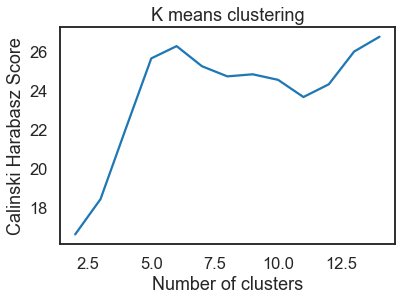

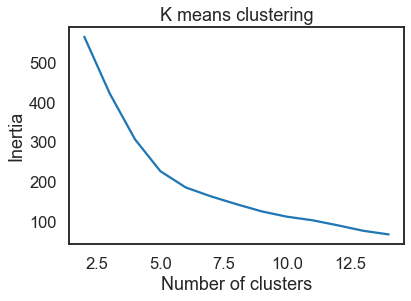

In [47]:
data = day_cluster_scaled

#pick cluster number based on silhouette coefficient
k_range = range(2,15)

base_scores = []
sil_scores = []
db_scores = []
ch_scores = []
mse_scores = []

for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=39)
    km_ss.fit(data)
    
    sil_scores.append(metrics.silhouette_score(data, km_ss.labels_))
    db_scores.append(metrics.davies_bouldin_score(data, km_ss.labels_))
    ch_scores.append(metrics.calinski_harabasz_score(data, km_ss.labels_))
    mse_scores.append(km_ss.inertia_)
    

# plot the results
plt.plot(k_range, sil_scores)
plt.title('K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

# plot the results
plt.plot(k_range, db_scores)
plt.title('K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin Score')
plt.show()

# plot the results
plt.plot(k_range, ch_scores)
plt.title('K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()
    
# plot the results
plt.plot(k_range, mse_scores)
plt.title('K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

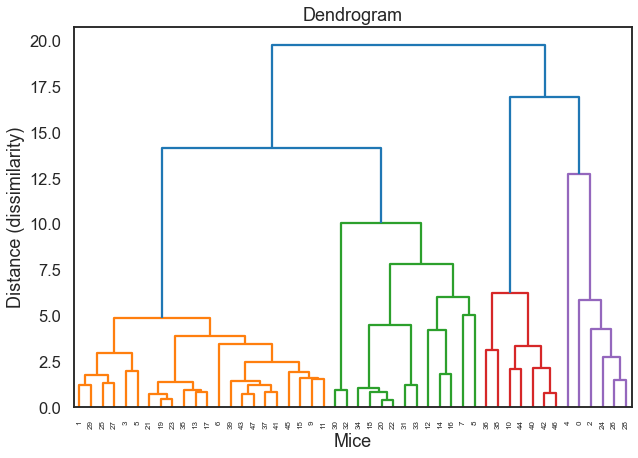

In [48]:
#viz dendrogram to find if three clusters makes sense
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
plt.ylabel("Distance (dissimilarity)")
plt.xlabel("Mice")
dend = shc.dendrogram(shc.linkage(day_cluster_scaled, method='ward'), 
                      distance_sort='ascending',
                      show_leaf_counts=True, leaf_font_size=8)

<Figure size 1440x1080 with 0 Axes>

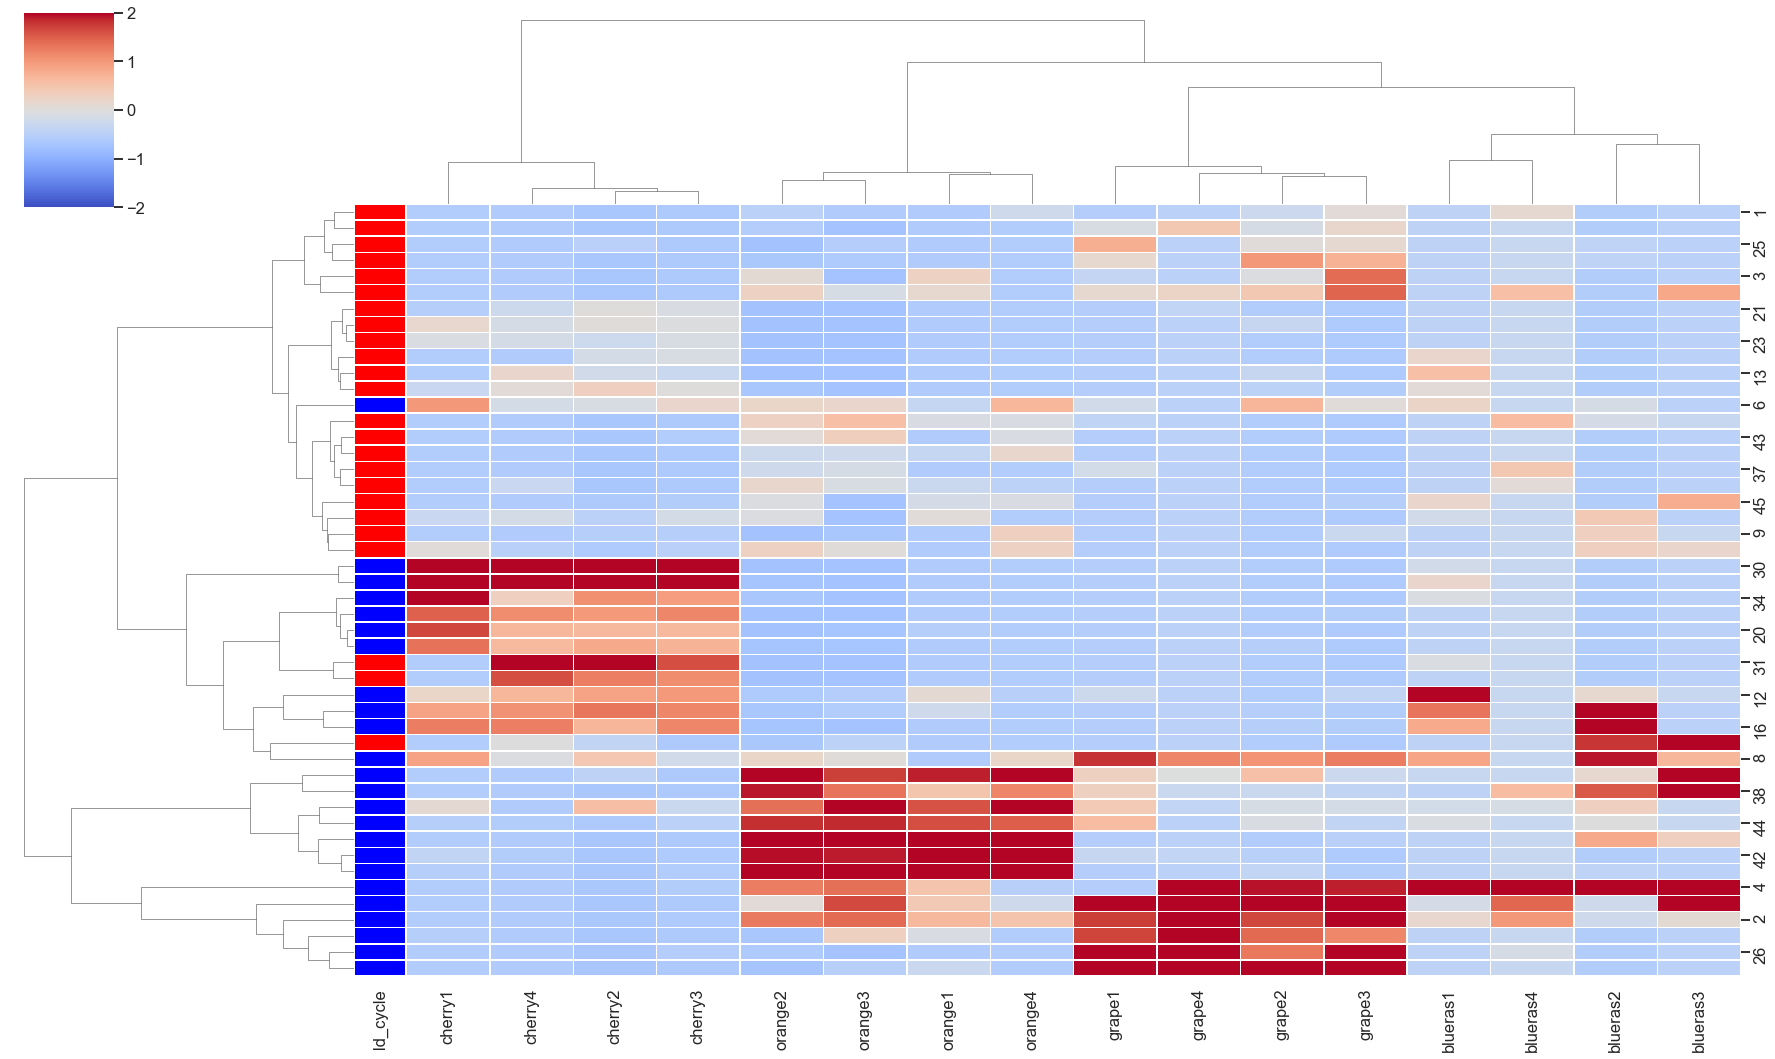

In [69]:
params = ['blueras1', 'blueras2', 'blueras3', 'blueras4',
                                'cherry1', 'cherry2', 'cherry3', 'cherry4',
                                'grape1', 'grape2', 'grape3', 'grape4',
                                'orange1', 'orange2', 'orange3', 'orange4',]

lut = dict(zip(unstack_flavor_day['ld_cycle'].unique(), "br"))
row_colors = unstack_flavor_day['ld_cycle'].map(lut)
plt.figure(figsize=(20,15))

g = sns.clustermap(unstack_flavor_day[params], row_colors=row_colors,
                 metric="euclidean", z_score=1, method="ward",
               vmin=-2, vmax=2, center=0, cmap = 'coolwarm', 
               square=True, linewidths=.5, cbar_kws={"shrink": .5}, figsize=(25,15))
plt.show()

In [49]:
#choose k=3 clusters and fit data
km_3 = KMeans(n_clusters=4,random_state=99)
km_3.fit(day_cluster_scaled)

unstack_flavor_day['kmeans_cluster'] = ["cluster_" + str(label) for label in km_3.labels_ ]
print(unstack_flavor_day.shape)
unstack_flavor_day.head(1)

(48, 21)


,Sex,Cage,IdRFID,ld_cycle,blueras1,blueras2,blueras3,blueras4,cherry1,cherry2,cherry3,cherry4,grape1,grape2,grape3,grape4,orange1,orange2,orange3,orange4,kmeans_cluster
0,female,3,041ABFE8D4,dark,0.05,0.05,0.425,0.2,0.0,0.0,0.0,0.0,1.026,2.43,1.404,0.621,0.336,0.48,1.56,0.12,cluster_0


### Viz

#### what can we see in the raw data

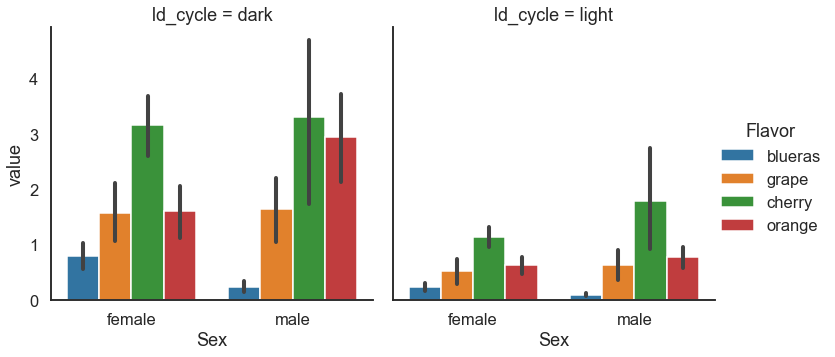

In [56]:
data_gb_sum = data_switch.groupby(['VDM_file', 'Sex', 'Cage', 'IdRFID', 
                                   'Flavor', 'ld_cycle'])['value',].sum().reset_index()

sns.catplot(x='Sex', y='value', data=data_gb_sum,  kind='bar', 
            ci=68, height=5, aspect=1, hue='Flavor', hue_order=['blueras', 'grape', 'cherry', 'orange'],
           col='ld_cycle')

plt.show()

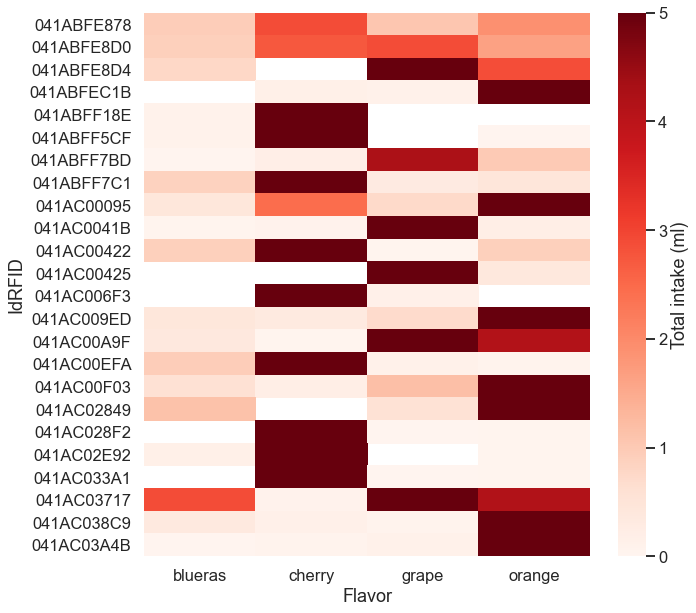

In [51]:
groupby = data_gb_sum.pivot('IdRFID', 'Flavor', "value")
plt.figure(figsize=(10,10))
ax = sns.heatmap(groupby, cmap="Reds", vmin=0, vmax=5, cbar_kws={'label': 'Total intake (ml)'})
    #plt.xlabel('Bottle')
plt.show()

#### do we see something more with the clustering

In [57]:
data_gb_sum = data_gb_sum.merge(unstack_flavor_day[['IdRFID', 'kmeans_cluster']], on='IdRFID')
print(data_gb_sum.shape)
data_gb_sum.head()

(286, 8)


,VDM_file,Sex,Cage,IdRFID,Flavor,ld_cycle,value,kmeans_cluster
0,br.c.g.o_switchfm_211220.csv,female,3,041ABFE8D4,blueras,dark,0.725,cluster_0
1,br.c.g.o_switchfm_211220.csv,female,3,041ABFE8D4,blueras,dark,0.725,cluster_2
2,br.c.g.o_switchfm_211220.csv,female,3,041ABFE8D4,blueras,light,0.050,cluster_0
3,br.c.g.o_switchfm_211220.csv,female,3,041ABFE8D4,blueras,light,0.050,cluster_2
4,br.c.g.o_switchfm_211220.csv,female,3,041ABFE8D4,grape,dark,5.481,cluster_0


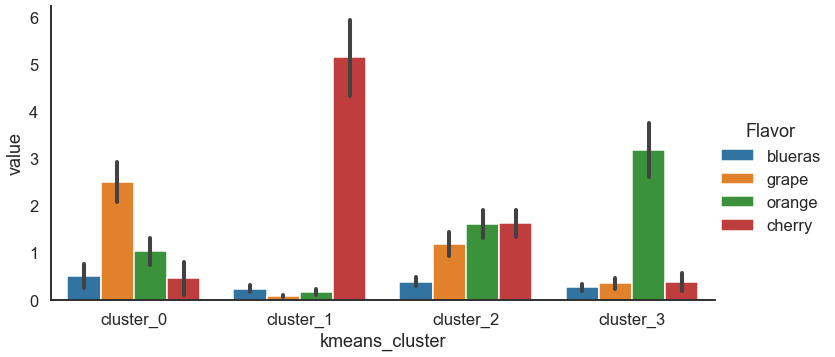

In [65]:
order = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', ]
sns.catplot(x='kmeans_cluster', y='value', kind='bar', ci=68, data=data_gb_sum, 
            height=5, aspect=2, hue='Flavor', order=order,
           )
plt.show()

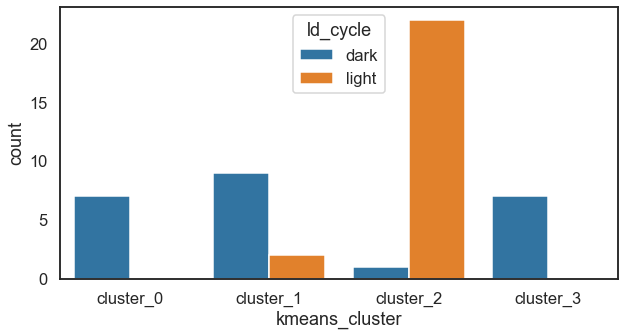

In [63]:
plt.figure(figsize=(10,5))

sns.countplot(x='kmeans_cluster', data=unstack_flavor_day, 
            hue='ld_cycle', order=order)
plt.show()

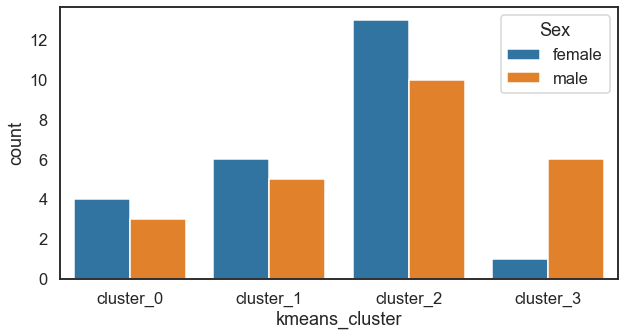

In [64]:
plt.figure(figsize=(10,5))

sns.countplot(x='kmeans_cluster', data=unstack_flavor_day, 
            hue='Sex', order=order)
plt.show()

<AxesSubplot:ylabel='kmeans_cluster'>

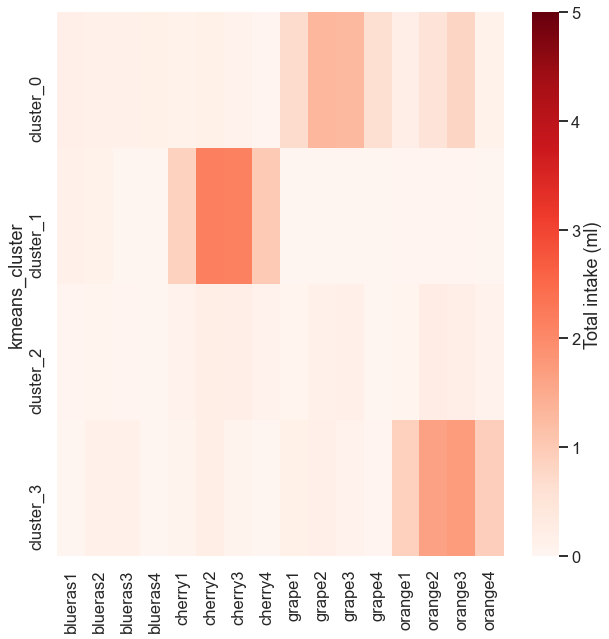

In [66]:
plt.figure(figsize=(10,10))
sns.heatmap(unstack_flavor_day.groupby('kmeans_cluster')[['blueras1', 'blueras2', 'blueras3', 'blueras4',
                                'cherry1', 'cherry2', 'cherry3', 'cherry4',
                                'grape1', 'grape2', 'grape3', 'grape4',
                                'orange1', 'orange2', 'orange3', 'orange4',]].mean(), 
            cmap="Reds", vmin=0, vmax=5, cbar_kws={'label': 'Total intake (ml)'})